# Kelompok 2 Project Akhir PKA (Wheat Detection)
1. Akhmad Faizal / 23/529787/PPA/06701
2. Wahyu Ajitomo / 23/529905/PPA/06703
3. Jihaad Arief Pangestu / 23/530550/PPA/06737
4. Evangelions Felix Yehdeya GSD / 23/530851/PPA/06749

## Import library

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive

## Data Loading and Unzip Data#

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/PKA_final_project/dataset/global-wheat-detection.zip

## Data Latih CSV

In [ ]:
data = pd.read_csv('/content/train.csv')

data.head(5)

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [ ]:
bbox_coordinates = pd.DataFrame(list(data.bbox.apply(lambda x : x[1:-1].split(",")).values),columns=["x1","y1","w","h"])

bbox_coordinates[:5]

x1      y1       w       h
0  834.0   222.0    56.0    36.0
1  226.0   548.0   130.0    58.0
2  377.0   504.0    74.0   160.0
3  834.0    95.0   109.0   107.0
4   26.0   144.0   124.0   117.0

In [ ]:
# Menghapus beberapa kolom yang tidak dibutuhkan
data = data.drop(['width', 'height', 'source', 'bbox'], axis = 1)

data.head()

image_id
0  b6ab77fd7
1  b6ab77fd7
2  b6ab77fd7
3  b6ab77fd7
4  b6ab77fd7

In [ ]:
data_image_unique = data['image_id'].unique()

data_image_unique.shape

(3373,)

In [ ]:
unique_image_id = pd.DataFrame(data_image_unique, columns=['image_id'])

unique_image_id.head()

3373


image_id
0  b6ab77fd7
1  b53afdf5c
2  7b72ea0fb
3  91c9d9c38
4  41c0123cc

In [ ]:
# Menggabungkan koordinat bbox kedalam baris data sesuai dengan masing-masing gambar
training_data = pd.concat([data, bbox_coordinates], axis = 1)

training_data.head()

image_id     x1      y1       w       h
0  b6ab77fd7  834.0   222.0    56.0    36.0
1  b6ab77fd7  226.0   548.0   130.0    58.0
2  b6ab77fd7  377.0   504.0    74.0   160.0
3  b6ab77fd7  834.0    95.0   109.0   107.0
4  b6ab77fd7   26.0   144.0   124.0   117.0

## Set the Directory Path

In [ ]:
training_image_dir = '/content/train'
testing_image_dir = '/content/test'

## List Image Files

In [ ]:
# Mengecek berapakah gambar yang bertipe .jpg/.png/.jpeg/ dan yang lainnya

png_count = 0
jpg_count = 0
jpeg_count = 0
other_count = 0

for file in os.listdir(training_image_dir):
  if file.endswith('.png'):
    png_count += 1
  elif file.endswith('.jpg'):
    jpg_count += 1
  elif file.endswith('.jpeg'):
    jpeg_count += 1
  else:
    other_count += 1

print("Gambar berformat PNG          : ", png_count)
print("Gambar berformat JPG          : ", jpg_count)
print("Gambar berformat JPEG         : ", jpeg_count)
print("Gambar berformat yang lainnya : ", other_count)
print("-------------------------------------- +")
print("Total gambar adalah           : ", (png_count+jpg_count+jpeg_count+other_count))

Gambar berformat PNG          :  0
Gambar berformat JPG          :  3422
Gambar berformat JPEG         :  0
Gambar berformat yang lainnya :  0
-------------------------------------- +
Total gambar adalah           :  3422


In [ ]:
# Menambahkan/menyambungkan agar setiap file pada gambar di dalam folder "train" bisa diakses melalui path masing-masing gambar
training_images = []

for file in os.listdir(training_image_dir):
  training_images.append(os.path.join(training_image_dir, file))

In [ ]:
training_images[:5]

['/content/train/afb9f53cd.jpg',
 '/content/train/4ecd10d42.jpg',
 '/content/train/39614e195.jpg',
 '/content/train/7bca11467.jpg',
 '/content/train/0874422e6.jpg']

## Display Sample Images

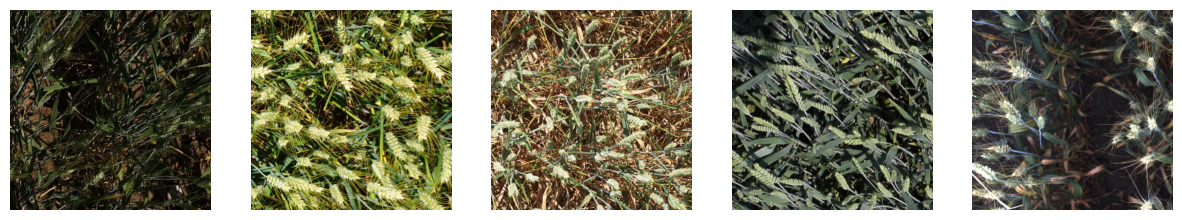

In [ ]:
def show_sample_images(image_files, num_images=5):
  plt.figure(figsize=(15, 10))
  for i in range(num_images):
    img = cv2.imread(image_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, num_images, i+1)
    plt.imshow(img)
    plt.axis('off')
  plt.show()

show_sample_images(training_images)

## Image Dimensions and Aspect Ratios

In [ ]:
dimensions = []
aspect_ratios = []

for file in training_images:
  img = cv2.imread(file)
  h, w = img.shape[:2]
  dimensions.append((w, h))
  aspect_ratios.append(w / h)

dimensions = np.array(dimensions)
aspect_ratios = np.array(aspect_ratios)

print(f"Min width: {dimensions[:, 0].min()}, Max width: {dimensions[:, 0].max()}")
print(f"Min height: {dimensions[:, 1].min()}, Max height: {dimensions[:, 1].max()}")
print(f"Mean aspect ratio: {aspect_ratios.mean()}")

Min width: 1024, Max width: 1024
Min height: 1024, Max height: 1024
Mean aspect ratio: 1.0


## Histogram of Color Channels

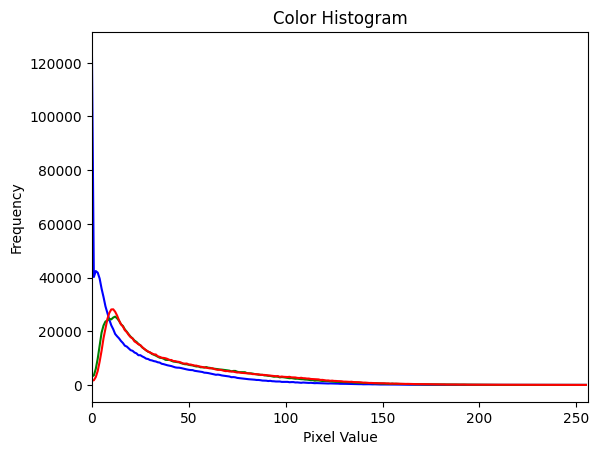

In [ ]:
def plot_color_histogram(image):
  colors = ('b', 'g', 'r')
  for i, col in enumerate(colors):
    hist = cv2.calcHist([image], [i], None, [256], [0, 256])
    plt.plot(hist, color=col)
    plt.xlim([0, 256])
  plt.title('Color Histogram')
  plt.xlabel('Pixel Value')
  plt.ylabel('Frequency')
  plt.show()

img = cv2.imread(training_images[0])
plot_color_histogram(img)

## Image Brightness and Contrast

In [ ]:
def calculate_brightness_contrast(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  brightness = np.mean(gray)
  contrast = np.std(gray)
  return brightness, contrast

brightness_values = []
contrast_values = []

for file in training_images:
  img = cv2.imread(file)
  brightness, contrast = calculate_brightness_contrast(img)
  brightness_values.append(brightness)
  contrast_values.append(contrast)

brightness_values = np.array(brightness_values)
contrast_values = np.array(contrast_values)

print(f"Mean brightness: {brightness_values.mean()}")
print(f"Mean contrast: {contrast_values.mean()}")

Mean brightness: 77.76847939795043
Mean contrast: 51.91130236249448
